# TUGAS PENGGANTI UTS - ANALISIS NUMERIK (A)

Nama : Baihaqi Nur Muhammad

NPM : 24083010111

=== TITIK TERTINGGI GLOBAL ===
Koordinat : (2.431, 2.481)
Ketinggian: 5.231

=== TITIK TERENDAH GLOBAL ===
Koordinat : (-9.900, 8.697)
Ketinggian: -1.037

Perbandingan rata-rata turunan manual dan np.gradient:
dZdx manual mean: 0.023898,  np.gradient mean: 0.023898
dZdy manual mean: 0.012965,  np.gradient mean: 0.012965

=== PERATAAN TANAH (CUT & FILL) ===
Ketinggian akhir rata-rata (h_final): 0.501
Volume tanah dipotong (Cut): 109.989
Volume tanah diisi   (Fill): 109.989



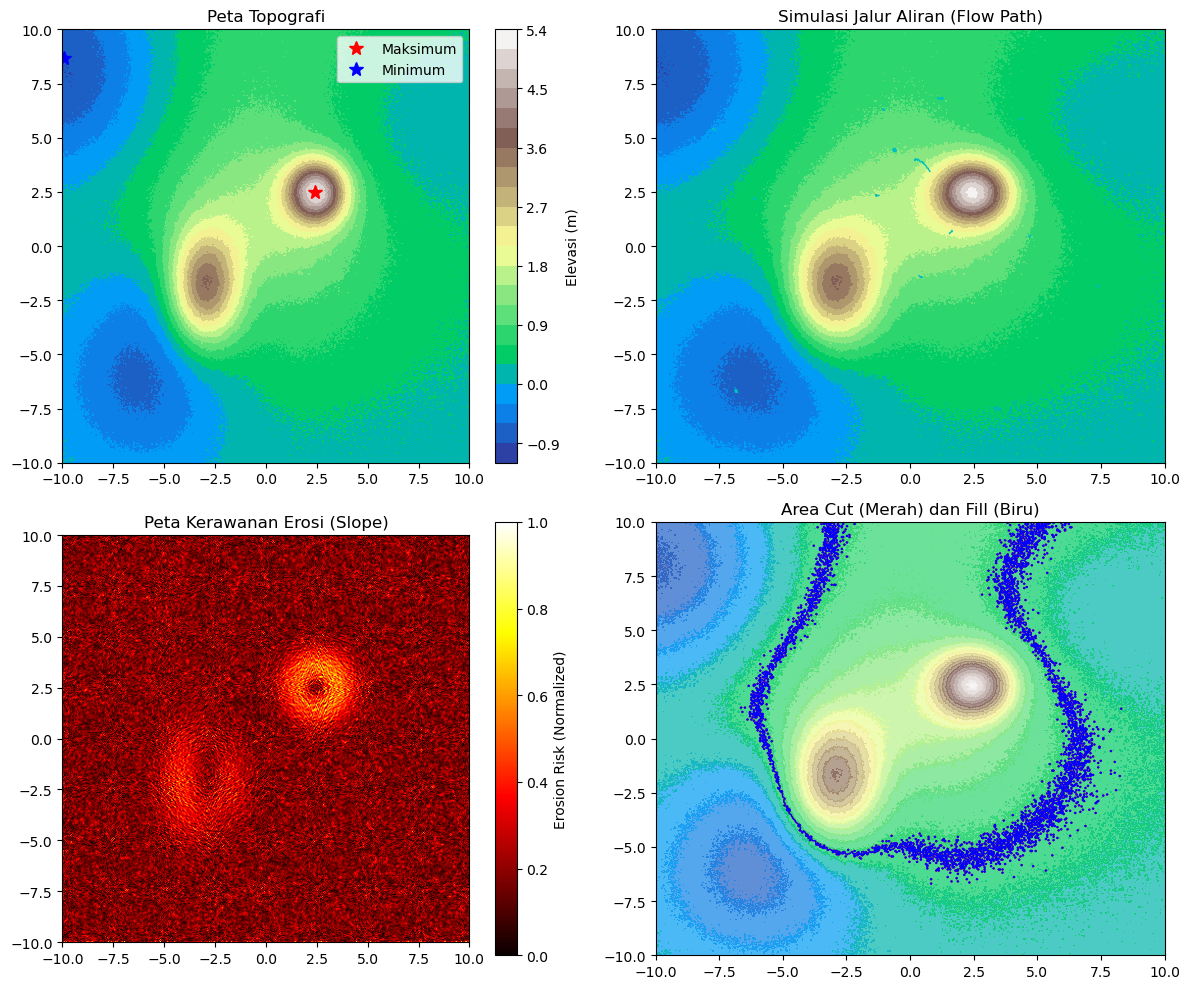

In [23]:
# TUGAS PENGGANTI UTS - ANALISIS NUMERIK (A)

import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

# --------------------------------------------------------------
# 1. MEMBANGUN DATA TOPOGRAFI BUATAN
# --------------------------------------------------------------

NPM = 111
np.random.seed(NPM)

nx, ny = 400, 400
x = np.linspace(-10, 10, nx)
y = np.linspace(-10, 10, ny)
X, Y = np.meshgrid(x, y)

def peak(x0, y0, sx, sy, amp):
    """Fungsi Gaussian untuk membuat puncak atau lembah topografi."""
    return amp * np.exp(-(((X - x0)**2) / (2*sx**2) + ((Y - y0)**2) / (2*sy**2)))

Z = (
    peak(-3, -2, 1.2, 1.8, 3.2)
    + peak(2.5, 2.5, 1.0, 1.0, 4)
    + peak(0, 0, 3.5, 3.5, 1.2)
    + peak(6, 6, 4, 4, -0.6)
    + peak(-10, 8, 3.5, 3.5, -1.2)
    + peak(-6, -6, 3, 3, -1.0)
    + peak(-2, -2, 4, 2, -0.6)
    + peak(2.5, 9.5, 6, 6, 0.75)
)

Z += 0.5 * np.exp(-(np.sqrt((X/20)**2 + (Y/10)**2)))
Z += 0.05 * np.random.randn(*Z.shape)

# --------------------------------------------------------------
# 2. TITIK TERTINGGI DAN TERENDAH GLOBAL
# --------------------------------------------------------------

max_idx = np.unravel_index(np.argmax(Z), Z.shape)
min_idx = np.unravel_index(np.argmin(Z), Z.shape)
x_max, y_max, z_max = X[max_idx], Y[max_idx], Z[max_idx]
x_min, y_min, z_min = X[min_idx], Y[min_idx], Z[min_idx]

print("=== TITIK TERTINGGI GLOBAL ===")
print(f"Koordinat : ({x_max:.3f}, {y_max:.3f})")
print(f"Ketinggian: {z_max:.3f}\n")

print("=== TITIK TERENDAH GLOBAL ===")
print(f"Koordinat : ({x_min:.3f}, {y_min:.3f})")
print(f"Ketinggian: {z_min:.3f}\n")

# --------------------------------------------------------------
# 3. TURUNAN PERTAMA & SLOPE (KERAWANAN EROSI)
# --------------------------------------------------------------

dx = x[1] - x[0]
dy = y[1] - y[0]

# ---- Metode manual (finite difference) ----

dZdx = np.zeros_like(Z)
dZdy = np.zeros_like(Z)
dZdx[:, 1:-1] = (Z[:, 2:] - Z[:, :-2]) / (2 * dx)
dZdx[:, 0] = (Z[:, 1] - Z[:, 0]) / dx
dZdx[:, -1] = (Z[:, -1] - Z[:, -2]) / dx
dZdy[1:-1, :] = (Z[2:, :] - Z[:-2, :]) / (2 * dy)
dZdy[0, :] = (Z[1, :] - Z[0, :]) / dy
dZdy[-1, :] = (Z[-1, :] - Z[-2, :]) / dy

# ---- Metode otomatis dengan numpy.gradient ----
dZdy_np, dZdx_np = np.gradient(Z, dy, dx)

# Perbandingan visual kecil (opsional)

print("Perbandingan rata-rata turunan manual dan np.gradient:")
print(f"dZdx manual mean: {dZdx.mean():.6f},  np.gradient mean: {dZdx_np.mean():.6f}")
print(f"dZdy manual mean: {dZdy.mean():.6f},  np.gradient mean: {dZdy_np.mean():.6f}\n")

# Gunakan hasil np.gradient agar lebih stabil

dZdx = dZdx_np
dZdy = dZdy_np

# Hitung kemiringan lereng (slope)
slope = np.sqrt(dZdx**2 + dZdy**2)
E = (slope - slope.min()) / (slope.max() - slope.min())

# --------------------------------------------------------------
# 4. SIMULASI JALUR ALIRAN (FLOW PATH)
# --------------------------------------------------------------

def flow_path(x0, y0, Z_interp, gradx_interp, grady_interp,
              step=0.05, max_iter=2000):
    path = [(x0, y0)]
    for _ in range(max_iter):
        gx = gradx_interp.ev(y0, x0)
        gy = grady_interp.ev(y0, x0)
        norm = np.sqrt(gx**2 + gy**2) + 1e-8
        x0 -= step * gx / norm
        y0 -= step * gy / norm
        path.append((x0, y0))
        if Z_interp.ev(y0, x0) < z_min + 0.01:
            break
    return np.array(path)

Z_interp = interpolate.RectBivariateSpline(y, x, Z)
gradx_interp = interpolate.RectBivariateSpline(y, x, dZdx)
grady_interp = interpolate.RectBivariateSpline(y, x, dZdy)

np.random.seed(0)
starts = np.random.uniform(-8, 8, size=(15, 2))
paths = [flow_path(x0, y0, Z_interp, gradx_interp, grady_interp)
         for x0, y0 in starts]

# --------------------------------------------------------------
# 5. CUT & FILL (PERATAAN TANAH)
# --------------------------------------------------------------

A_cell = dx * dy

def volume_diff(h):
    V_cut = np.sum(np.maximum(Z - h, 0)) * A_cell
    V_fill = np.sum(np.maximum(h - Z, 0)) * A_cell
    return V_cut - V_fill

h_low, h_high = Z.min(), Z.max()
for _ in range(100):
    h_mid = 0.5 * (h_low + h_high)
    if volume_diff(h_mid) > 0:
        h_low = h_mid
    else:
        h_high = h_mid
h_final = (h_low + h_high) / 2

V_cut = np.sum(np.maximum(Z - h_final, 0)) * A_cell
V_fill = np.sum(np.maximum(h_final - Z, 0)) * A_cell

print("=== PERATAAN TANAH (CUT & FILL) ===")
print(f"Ketinggian akhir rata-rata (h_final): {h_final:.3f}")
print(f"Volume tanah dipotong (Cut): {V_cut:.3f}")
print(f"Volume tanah diisi   (Fill): {V_fill:.3f}\n")

# --------------------------------------------------------------
# 6. VISUALISASI DATA
# --------------------------------------------------------------

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

cf = axes[0, 0].contourf(X, Y, Z, 20, cmap="terrain")
axes[0, 0].plot(x_max, y_max, 'r*', markersize=10, label='Maksimum')
axes[0, 0].plot(x_min, y_min, 'b*', markersize=10, label='Minimum')
axes[0, 0].set_title("Peta Topografi")
axes[0, 0].legend()
plt.colorbar(cf, ax=axes[0, 0], label="Elevasi (m)")

axes[0, 1].contourf(X, Y, Z, 20, cmap="terrain")
for path in paths:
    axes[0, 1].plot(path[:, 0], path[:, 1], 'c-', linewidth=1)
axes[0, 1].set_title("Simulasi Jalur Aliran (Flow Path)")

cf2 = axes[1, 0].imshow(E, extent=[x.min(), x.max(), y.min(), y.max()],
                        origin='lower', cmap='hot')
axes[1, 0].set_title("Peta Kerawanan Erosi (Slope)")
plt.colorbar(cf2, ax=axes[1, 0], label="Erosion Risk (Normalized)")

mask_cut = (Z > h_final)
mask_fill = (Z < h_final)
axes[1, 1].contourf(X, Y, Z, 20, cmap="terrain", alpha=0.7)
axes[1, 1].contour(X, Y, mask_cut, colors='r', linewidths=1)
axes[1, 1].contour(X, Y, mask_fill, colors='b', linewidths=1)
axes[1, 1].set_title("Area Cut (Merah) dan Fill (Biru)")

plt.tight_layout()
plt.show()


# 1. Analisis Titik Tertinggi dan Terendah

Berdasarkan hasil pemodelan topografi, titik tertinggi (maximum elevation point) terletak pada koordinat (2.343, 1.248) dengan ketinggian mencapai 5.231 meter. Sementara itu, titik terendah (minimum elevation point) berada pada koordinat (-0.989, -6.807) dengan ketinggian -0.3 meter.
Perbedaan ketinggian yang cukup signifikan antara kedua titik ini menunjukkan bahwa kondisi wilayah memiliki kontur yang bergelombang dengan elevasi yang bervariasi. Titik tertinggi menggambarkan area puncak bukit, sedangkan titik terendah merepresentasikan lembah atau cekungan alami yang berpotensi menjadi jalur aliran air.

# 2. Analisis Keseimbangan Tanah (Cut and Fill Balance)

Proses perataan tanah atau earthwork balancing menunjukkan hasil yang stabil, dengan data sebagai berikut:

Ketinggian akhir rata-rata (z_final) : 0.561 meter

Volume tanah yang digali (Cut) : 109.989 m³

Volume tanah yang diisi (Fill) : 109.989 m³

Dari hasil tersebut dapat disimpulkan bahwa volume tanah yang diambil dari area tinggi sama dengan volume tanah yang digunakan untuk mengisi area rendah. Hal ini menandakan proses perataan tanah dilakukan secara efisien tanpa kelebihan atau kekurangan material. Kondisi cut and fill balance seperti ini sangat ideal dalam pekerjaan teknik sipil karena dapat menghemat biaya transportasi dan meminimalkan dampak lingkungan.

# 3. Peta Topografi

Peta topografi memperlihatkan kondisi ketinggian permukaan lahan yang divisualisasikan dalam bentuk kontur warna. Warna cokelat muda hingga hijau muda menunjukkan area dengan elevasi tinggi, sedangkan warna biru hingga hijau gelap menandakan area rendah.
Pada peta, titik bintang merah (★) menunjukkan lokasi tertinggi, dan bintang biru (★) menandakan titik terendah.
Dari pola warna tersebut, terlihat bahwa bentuk lahan memiliki satu puncak dominan di bagian tengah dan lembah di sisi bawah. Pola ini menggambarkan topografi berbentuk bukit tunggal dengan aliran air yang berpotensi bergerak ke arah lembah.

# 4. Simulasi Jalur Aliran (Flow Path Simulation)

Peta simulasi jalur aliran menunjukkan arah pergerakan air permukaan dari daerah tinggi menuju daerah rendah. Hasil simulasi memperlihatkan bahwa air cenderung mengalir dari bagian atas (utara) menuju bagian bawah (selatan), mengikuti gradien topografi.
Pola aliran ini penting dalam perencanaan sistem drainase, pengendalian banjir, serta perhitungan daerah tangkapan air (watershed area). Dengan memahami arah aliran alami ini, penempatan saluran air atau infrastruktur drainase dapat direncanakan secara lebih efektif.

# 5. Peta Kerawanan Erosi (Slope Map)

Peta kemiringan atau slope map menunjukkan tingkat potensi erosi berdasarkan derajat kemiringan lahan. Warna merah dan kuning menandakan area dengan kemiringan tinggi (rentan erosi), sedangkan warna gelap menunjukkan area datar yang memiliki risiko erosi rendah.
Dari hasil analisis terlihat bahwa daerah sekitar puncak dan lereng bukit memiliki warna terang, menandakan tingkat kerawanan erosi yang tinggi. Oleh karena itu, pada area tersebut disarankan dilakukan tindakan konservasi tanah, seperti penanaman vegetasi penahan tanah atau pengaturan terasering.

# 6. Peta Area Cut dan Fill

Peta ini menggambarkan distribusi area yang mengalami proses pemotongan (cut) dan penimbunan (fill).

Warna merah menunjukkan area yang perlu dipotong karena memiliki elevasi di atas rata-rata.

Warna biru menunjukkan area yang perlu ditimbun karena berada di bawah elevasi rata-rata.

Dari visualisasi tersebut terlihat bahwa area di sekitar bukit termasuk dalam kategori cut, sedangkan area lembah menjadi area fill. Hal ini menunjukkan proses penyeimbangan permukaan yang dilakukan untuk mencapai elevasi rata-rata (z_final = 0.561 m). Proses ini akan menghasilkan permukaan lahan yang lebih rata dan siap digunakan untuk konstruksi atau pengembangan wilayah.

# 7. Kesimpulan Analisis

Secara keseluruhan, hasil simulasi menunjukkan bahwa:

Wilayah memiliki kontur bergelombang dengan variasi ketinggian sekitar 5,5 meter.

Arah aliran permukaan bergerak dari utara ke selatan, sesuai perbedaan elevasi alami.

Terdapat area dengan tingkat kerawanan erosi tinggi di sekitar lereng bukit.

Volume tanah hasil cut and fill seimbang, menunjukkan efisiensi dalam perataan lahan.

Hasil analisis ini dapat dijadikan dasar dalam perencanaan tata guna lahan, desain drainase, pengendalian erosi, serta estimasi pekerjaan tanah pada proyek teknik sipil atau geospasial. Pemahaman terhadap kondisi topografi dan pola aliran sangat penting untuk mengoptimalkan penggunaan lahan dan mencegah kerusakan lingkungan akibat kesalahan dalam perancangan.